# Figures pour le papier Digital Twins

In [37]:
from snake_ai.envs import RandomObstaclesEnv
import scipy.sparse as sp
import numpy as np
import phi.flow as pf
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splinalg
import tqdm

## Définition des différences finies

In [62]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")


def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [63]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

In [64]:
def apply_dirichlet_2D(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
    """
    res = binary_map.shape
    max_index = np.prod(res)
    rhs = np.zeros(max_index)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols = np.nonzero(binary_map)   
    for i, j in tqdm.tqdm(zip(rows, cols), total=len(rows)):
        index = sub2ind_2D(res, i, j)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j]
        
        ind_o = sub2ind_2D(res, i + 1, j)
        ind_e = sub2ind_2D(res, i - 1, j)
        ind_n = sub2ind_2D(res, i, j + 1)
        ind_s = sub2ind_2D(res, i, j - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs

## Utilisation d'environements existants

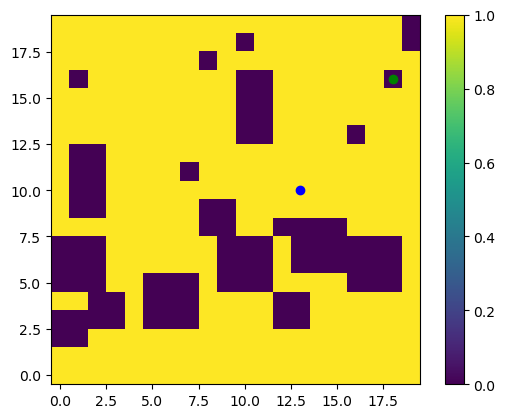

In [65]:
env = RandomObstaclesEnv(pixel=1, nb_obs=20, max_obs_size=3)
env.reset()
plt.imshow(env._free_position_mask, origin='lower')
plt.plot(env.goal.y, env.goal.x, 'go')
plt.plot(env.agent.position.y, env.agent.position.x, 'bo')
plt.colorbar()

# Definition d'environement à partir de carte binaires 

In [66]:
binary_map = np.array([
    [0, 0,0,0,0,0,0,0,0,0, 0],
    [0, 0,0,0,0,0,0,0,0,0, 0],
    [0, 0,1,1,1,0,1,1,1,0, 0],
    [0, 0,1,1,1,0,0,0,1,0, 0],
    [0, 0,1,1,1,1,1,0,1,0, 0],
    [0, 0,1,0,0,0,0,0,1,0, 0],
    [0, 0,1,0,1,1,1,1,1,0, 0],
    [0, 0,1,0,0,0,1,1,1,0, 0],
    [0, 0,1,1,1,0,1,1,1,0, 0],
    [0, 0,0,0,0,0,0,0,0,0, 0],
    [0, 0,0,0,0,0,0,0,0,0, 0],
])
binary_map.shape

(11, 11)

In [67]:
res = 10
x_max, y_max = binary_map.shape

new_obs_map = np.zeros((x_max * res, y_max * res))
for x, y in np.argwhere(binary_map):
    new_obs_map[x*res:(x+1)*res, y*res:(y+1)*res] = 1

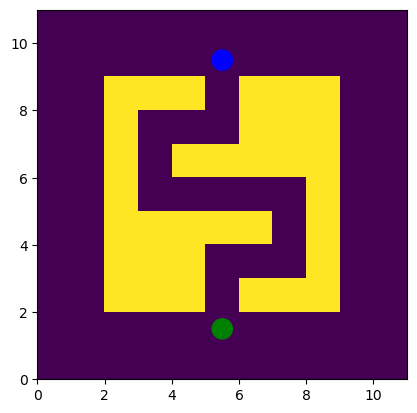

In [68]:
init_pos = np.array([5.5, 1.5])
goal_pos = np.array([5.5, 9.5])
fig, ax = plt.subplots()
ax.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])
ax.add_patch(plt.Circle(init_pos, 0.3, color="green"))
ax.add_patch(plt.Circle(goal_pos, 0.3, color="blue"))   

100%|██████████| 1/1 [00:00<00:00, 1203.53it/s]


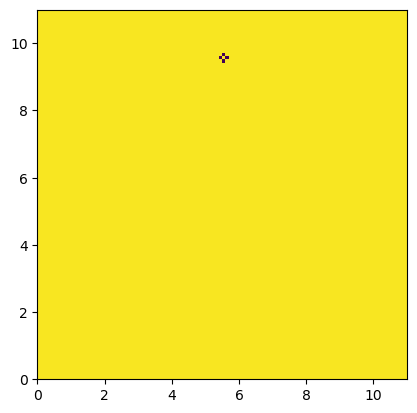

In [81]:
## 
step = np.array(binary_map.shape) / np.array(new_obs_map.shape)
laplace = create_laplacian_matrix_2d(*new_obs_map.shape, *step)
rhs = np.zeros(new_obs_map.shape)
goal_ind = goal_pos * res
rhs[int(goal_ind[1]), int(goal_ind[0])] = 1e3
laplace, rhs = apply_dirichlet_2D(laplace, rhs)
plt.imshow(rhs.reshape(new_obs_map.shape), origin='lower', extent=[0, x_max, 0, y_max])
# plt.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])

In [82]:
valid_ind = new_obs_map.flat != 0
A = laplace[valid_ind][:, valid_ind]
b = rhs.flat[valid_ind]
x = splinalg.spsolve(A, b)
solution = np.zeros(new_obs_map.shape)
solution.flat[valid_ind] = x

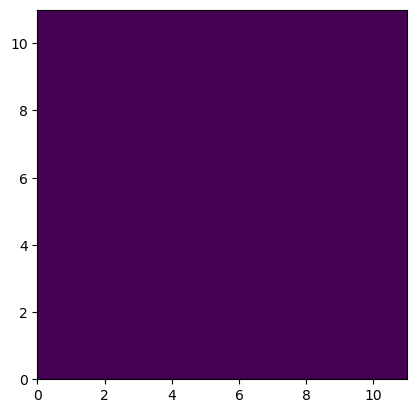

In [83]:
plt.imshow(solution, origin='lower', extent=[0, x_max, 0, y_max])